In [73]:
##defining the central server

import flwr as fl

def start_server():
    print("Starting server...")
    strategy = fl.server.strategy.FedAvg()
    fl.server.start_server(
        server_address="localhost:8080",
        config=fl.server.ServerConfig(num_rounds=3),
        strategy=strategy
    )
    print("Server finished.")



### Defining the client servers through Flower

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import flwr as fl
import numpy as np

global acc
acc = {}

def randomize_initial_parameters(shape):
    # Sample weights from a normal distribution
    weights = np.random.normal(size=shape)
    # Sample bias from a uniform distribution
    bias = np.random.uniform(size=(1,))
    return weights, bias

class CreditCardClient(fl.client.NumPyClient):
    def __init__(self, X_train, y_train, client_id, max_iter, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = LogisticRegression(max_iter=max_iter)
        self.client_id = client_id
        self.coefs_ = None

        # Randomize initial parameters
        initial_weights, initial_bias = randomize_initial_parameters((1, X_train.shape[1]))
        self.model.coef_ = initial_weights
        self.model.intercept_ = initial_bias
#         print(initial_weights)

        print(f"Client {self.client_id} initialized with {len(X_train)} samples.")


    def get_parameters(self, config):
        if hasattr(self.model, "coef_"):
            print("in hasattr")
            return [self.model.coef_.ravel(), self.model.intercept_]
        else:
            n_features = self.X_train.shape[1]
            return [np.zeros(n_features), np.zeros(1)]

    def set_parameters(self, parameters):
        self.model.coef_ = np.array(parameters[0]).reshape(1, -1)
        self.model.intercept_ = np.array(parameters[1])

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.fit(self.X_train, self.y_train)
        self.coefs_ = (self.model.coef_, self.model.intercept_)
        print(f"Client {self.client_id} training complete.")
        return self.get_parameters(config), len(self.X_train), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        self.y_pred = self.model.predict(self.X_test)
        print(self.y_pred)
        accuracy = accuracy_score(self.y_test, self.y_pred)
        precision = precision_score(self.y_test, self.y_pred)
        recall = recall_score(self.y_test, self.y_pred)
        f1 = f1_score(self.y_test, self.y_pred)
        
        if self.client_id not in acc.keys():
            acc[self.client_id] = [accuracy]
        else:
            acc[self.client_id].append(accuracy)
            
        print(f"Client {self.client_id} evaluation complete. Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}")
        return float(accuracy), len(self.X_test), {}
   
    

### Loading the data

In [75]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time
import threading

# Load and preprocess the data
# data = pd.read_csv(r"C:\Users\jahan\Downloads\archive (6)\UCI_Credit_Card.csv")

data = pd.read_csv(r"C:\Users\jahan\Downloads\dataset_1.csv")
### new_df = data.drop(columns = ["BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6","PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6",
###                             "PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"])

data = data.dropna()

new_df = data.drop(columns=["person_home_ownership"])
X = new_df.drop(columns=["loan_default"])
X_shuffled = X.sample(frac=1, random_state=42).reset_index(drop=True)
y = new_df['loan_default']


In [76]:
new_df

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_default,loan_percent_income,previous_default
0,0.016129,0.009173,1.000000,1.000000,0.595506,1,0.59,1
1,0.008065,0.000934,0.040650,0.014493,0.321348,0,0.10,0
2,0.040323,0.000934,0.008130,0.144928,0.418539,1,0.57,0
3,0.024194,0.010257,0.032520,1.000000,0.551124,1,0.53,0
4,0.032258,0.008406,0.065041,1.000000,0.497191,1,0.55,1
...,...,...,...,...,...,...,...,...
32576,0.298387,0.008172,0.008130,0.153623,0.434831,0,0.11,0
32577,0.274194,0.019346,0.032520,0.496377,0.116292,0,0.15,0
32578,0.362903,0.012008,0.024390,1.000000,0.312921,1,0.46,0
32579,0.290323,0.024350,0.040650,0.420290,0.340449,0,0.10,0


### Dividing the data between clients and setting the partition

In [77]:

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# # Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split training data among multiple clients
num_clients = 10
client_data = []
for i in range(num_clients):
    start_train = i * len(X_train) // num_clients
    end_train = (i + 1)* len(X_train) // num_clients
    
    start_test = i * len(X_test) // num_clients
    end_test = (i + 1)* len(X_test) // num_clients
    
    client_data.append((X_train[start_train:end_train], y_train[start_train:end_train],X_test[start_test:end_test], y_test[start_test:end_test]))
    


### Initialising the server and clients - Threading

In [78]:
# Define a function to start a client
def start_client(client_data, client_id, itera):
    X_train, y_train, X_test, y_test = client_data
    client = CreditCardClient(X_train, y_train, client_id, itera, X_test, y_test)
    print("Starting client...")
    fl.client.start_client(server_address="localhost:8080", client=client)
    print(f"Client {client_id} finished.")
    return client.coefs_

# Start the server in a separate thread
server_thread = threading.Thread(target=start_server)
server_thread.start()

# Wait a bit to ensure the server is up
time.sleep(5)
print("Server should be up now.")

# Start the clients
client_threads = []
client_coefs = []

def client_wrapper(client_data, client_id, itera):
    coefs = start_client(client_data, client_id, itera)
    client_coefs.append((client_id, coefs))

itera = 100
for idx, data in enumerate(client_data):
    client_thread = threading.Thread(target=client_wrapper, args=(data, idx, itera))
    client_thread.start()
    client_threads.append(client_thread)

# Wait for all clients to finish
for thread in client_threads:
    thread.join()

# Wait for the server to finishhttp://localhost:8888/notebooks/Fedearted%20learning%20code.ipynb#
server_thread.join()

print("All clients and server finished.")

# Print model coefficients for each client
for client_id, coefs in client_coefs:
    coef, intercept = coefs
    print(f"Client {client_id} coefficients: {coef}")
    print(f"Client {client_id} intercept: {intercept}")


INFO :      Starting Flower server, config: num_rounds=3, no round_timeout
INFO :      Flower ECE: gRPC server running (3 rounds), SSL is disabled
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Starting server...


INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      Received: get_parameters message b376208d-2bd3-4196-8988-8913a0d2d917
INFO :      Sent reply
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      


Server should be up now.
Client 0 initialized with 2291 samples.
Starting client...
Client 1 initialized with 2291 samples.
Starting client...
Client 2 initialized with 2291 samples.
Starting client...
Client 3 initialized with 2291 samples.
Starting client...
Client 4 initialized with 2291 samples.
Starting client...
Client 5 initialized with 2291 samples.
Starting client...
Client 6 initialized with 2291 samples.
Starting client...
Client 7 initialized with 2291 samples.
Starting client...
Client 8 initialized with 2291 samples.
Starting client...
Client 9 initialized with 2291 samples.
Starting client...
in hasattr


INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      
INFO :      Received: train message 6ffb4d55-7673-4183-a29a-6fb0a30af203
INFO :      
INFO :      
INFO :      
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      Received: train message 613a4243-eb2d-491d-92fe-d3da5460d05b
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      Received: train message 7aff1677-f645-46d5-8ca7-9cb9f0a139cf
INFO :      [RUN 0, ROUND ]
INFO :      Received: train message fd9c8533-8f26-4bd5-909f-0ceec93bf191
INFO :      Received: train message 52f56477-ef4c-4904-9322-313cb490954a
INFO :      Received: train message 591757ca-77d3-4ed4-b479-89a2f2242162
INFO :      Received: train message c32b1ed3-8c06-4989-8f6a-0e88a45e72e8
INFO :      Received: train message 33fd58f3-2330-42c2-89ec-3851558aefc7
INFO :      Receive

Client 6 training complete.
in hasattr
Client 5 training complete.
in hasattr
Client 4 training complete.
in hasattr


INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      
INFO :      Received: evaluate message b7cf8313-23c3-4440-ae29-1557a01c2b0f
INFO :      
INFO :      
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      Received: evaluate message 581e2842-e0f0-4112-a543-d3d9674eef86
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]


Client 9 training complete.
in hasattr
Client 1 training complete.
in hasattr
Client 3 training complete.
in hasattr
Client 2 training complete.
in hasattr
Client 0 training complete.
in hasattr
Client 8 training complete.
in hasattr
Client 7 training complete.
in hasattr
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0

INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      Received: evaluate message e47066a8-877e-4cab-8a8e-41dcbda31078
INFO :      [RUN 0, ROUND ]
INFO :      Received: evaluate message 84d28630-b3b9-455e-8587-7dedaea2c26b
INFO :      Received: evaluate message 0d6f5595-d7e8-417d-9598-99029b4a270b
INFO :      Received: evaluate message 2af9b9c2-3d1f-42b0-93e5-5b92a7feaa96
INFO :      Received: evaluate message ad1ebfe6-f7da-4a81-9fc0-cbb0ce79c72c
INFO :      Received: evaluate message 918423c0-9d08-410f-960c-578f124bf8d5
INFO :      Received: evaluate message 95096b12-7a60-4138-ba31-b9237497bcf5
INFO :      Received: evaluate message d93860fc-2842-4373-9a49-7f953be97665
INFO :      Sent reply


[0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0
 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      


Client 1 evaluation complete. Accuracy: 0.8342059336823735, Precision: 0.7101449275362319, Recall: 0.3951612903225806, F1-score: 0.5077720207253886
Client 7 evaluation complete. Accuracy: 0.8342059336823735, Precision: 0.7887323943661971, Recall: 0.4117647058823529, F1-score: 0.5410628019323671
Client 6 evaluation complete. Accuracy: 0.8254799301919721, Precision: 0.6486486486486487, Recall: 0.39344262295081966, F1-score: 0.4897959183673469
Client 5 evaluation complete. Accuracy: 0.8146853146853147, Precision: 0.6578947368421053, Recall: 0.38461538461538464, F1-score: 0.4854368932038835
Client 4 evaluation complete. Accuracy: 0.8027923211169284, Precision: 0.6142857142857143, Recall: 0.3333333333333333, F1-score: 0.4321608040201005
Client 0 evaluation complete. Accuracy: 0.8531468531468531, Precision: 0.7741935483870968, Recall: 0.4067796610169492, F1-score: 0.5333333333333333
Client 8 evaluation complete. Accuracy: 0.8342059336823735, Precision: 0.7066666666666667, Recall: 0.420634920

INFO :      Received: train message 75d0d2eb-ae31-43a9-a62f-b43e92b90746
INFO :      
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      Received: train message 170dfe38-a5c7-4214-99d7-0e364547fbb5
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      Received: train message b9d4268f-26a4-4515-b61f-6dd64d39c18f
INFO :      [RUN 0, ROUND ]
INFO :      Received: train message 363ddf14-9c28-43cd-964b-a9cd1611c859
INFO :      [RUN 0, ROUND ]
INFO :      Received: train message 7099f015-1633-4010-bae9-73e28731d34a
INFO :      Received: train message 561e507a-7000-4dd9-98c9-25aa73affaa4
INFO :      Received: train message 5776d926-c257-4ea9-b077-60ce188612fb
INFO :      Received: train message 0873877a-f3f8-41f2-8402-b486f511bc9a
INFO :      Received: train message 5b1b18ae-de8a-4386-af2f-f71fd669a9e3
INFO :      Received: train message ac93d8e5-495e-4fd3-b296-8b66673

Client 3 training complete.
in hasattr
Client 9 training complete.
in hasattr
Client 0 training complete.
in hasattr
Client 1 training complete.
in hasattr
Client 8 training complete.
in hasattr
Client 5 training complete.
in hasattr
Client 6 training complete.
in hasattr
Client 7 training complete.
in hasattr


INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      
INFO :      Received: evaluate message 64205d25-9319-42fa-a087-54645268d6b3
INFO :      
INFO :      
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      
INFO :      Received: evaluate message bca57e5c-2dab-4cd5-bad3-1b76d7595f16
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      Received: evaluate message d1d915a5-808a-46e5-bcd7-65972f998ed3
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      Received: evaluate message fba48fc2-3518-4024-9f58-30d05a802fda
INFO :      Received: evaluate message 38b9ad8c-7960-45c3-b246-1e62620b9e83
INFO : 

Client 2 training complete.
in hasattr
Client 4 training complete.
in hasattr
[0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0

INFO :      Received: evaluate message 0e013a23-338e-4ec8-a550-f7fa97d6103c
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply


[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 

INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      
INFO :      
INFO :      Received: train message f2b1e6e5-bd3e-456a-a5d9-7fda1f3e737a
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      Received: train message 5304c091-7cca-43c5-81ec-c046a988c499
INFO :      [RUN 0, ROUND ]
INFO :      Received: train message d4a34253-0a3e-4a1f-bade-02f89119b75b
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      Received: train message d317d

Client 9 evaluation complete. Accuracy: 0.8237347294938918, Precision: 0.7692307692307693, Recall: 0.4195804195804196, F1-score: 0.5429864253393665
Client 3 evaluation complete. Accuracy: 0.8289703315881326, Precision: 0.7534246575342466, Recall: 0.4074074074074074, F1-score: 0.5288461538461539
Client 5 evaluation complete. Accuracy: 0.8146853146853147, Precision: 0.6578947368421053, Recall: 0.38461538461538464, F1-score: 0.4854368932038835
Client 8 evaluation complete. Accuracy: 0.8342059336823735, Precision: 0.7066666666666667, Recall: 0.42063492063492064, F1-score: 0.527363184079602
Client 1 evaluation complete. Accuracy: 0.8342059336823735, Precision: 0.7101449275362319, Recall: 0.3951612903225806, F1-score: 0.5077720207253886
Client 6 evaluation complete. Accuracy: 0.8254799301919721, Precision: 0.6486486486486487, Recall: 0.39344262295081966, F1-score: 0.4897959183673469
Client 4 evaluation complete. Accuracy: 0.8027923211169284, Precision: 0.6142857142857143, Recall: 0.333333333

INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      


Client 5 training complete.
in hasattr
Client 0 training complete.
in hasattr
Client 9 training complete.
in hasattr
Client 3 training complete.
in hasattr
Client 4 training complete.
in hasattr
Client 1 training complete.
in hasattr
Client 7 training complete.
in hasattr
Client 6 training complete.
in hasattr
Client 8 training complete.
in hasattr


INFO :      Received: evaluate message 25a7eb99-dc50-400b-ac16-6fe42043a80f
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      Received: evaluate message 151c2718-963d-4302-9345-374800453c34
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      Received: evaluate message d25f0a45-59ef-4e37-9114-63d4d3f6eebd
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      Received: evaluate message f027e085-d8f8-44cd-b9b5-68261d2f3493
INFO :      Received: evaluate message febb5040-9aa6-4583-940d-d65238dcfbd3
INFO :      Received: evaluate message f8a5284b-ccb1-4c1d-ba93-ef8390510897
INFO :      Received: evaluate message c3358b4b-59e4-458b-8617-2a8af2b1da64
INFO :      Received: evaluate message 57e5c13e-d331-437f-bbfd-1056a484e635
INFO :      Received: evaluate message cbbc2d65-fdcb-4fc7-b03a-5b8a55fee8eb
INFO :      Received: evaluate message bf6d1e12-8102-40ce-9c26-1b5bb6db2c38


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 1 1 0 

INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      Sent reply
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 rounds in 2.57s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.8273393742677719\n'
INFO :      	 '\tround 2: 0.8273393742677719\n'


Client 6 evaluation complete. Accuracy: 0.8254799301919721, Precision: 0.6486486486486487, Recall: 0.39344262295081966, F1-score: 0.4897959183673469
Client 7 evaluation complete. Accuracy: 0.8342059336823735, Precision: 0.7887323943661971, Recall: 0.4117647058823529, F1-score: 0.5410628019323671
Client 8 evaluation complete. Accuracy: 0.8342059336823735, Precision: 0.7066666666666667, Recall: 0.42063492063492064, F1-score: 0.527363184079602
Client 0 evaluation complete. Accuracy: 0.8531468531468531, Precision: 0.7741935483870968, Recall: 0.4067796610169492, F1-score: 0.5333333333333333
Client 5 evaluation complete. Accuracy: 0.8146853146853147, Precision: 0.6578947368421053, Recall: 0.38461538461538464, F1-score: 0.4854368932038835
Client 3 evaluation complete. Accuracy: 0.8289703315881326, Precision: 0.7534246575342466, Recall: 0.4074074074074074, F1-score: 0.5288461538461539
Client 2 evaluation complete. Accuracy: 0.8219895287958116, Precision: 0.6515151515151515, Recall: 0.352459016

INFO :      	 '\tround 3: 0.8273393742677719\n')
INFO :      
INFO :      
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      
INFO :      Received: reconnect message cc72fe2a-bd33-4239-9f41-d1ca1edaa386
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      
INFO :      
INFO :      
INFO :      [RUN 0, ROUND ]
INFO :      Received: reconnect message a6dc6c48-8786-408a-9b3c-7118fa93451f
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      Received: reconnect message f4a5d91b-bbad-474d-ae30-96b7f9534c1e
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      [RUN 0, ROUND ]
INFO :      Received: reconnect message 458d090f-ab59-482e-9e3e-d0bf4c8d9af1
INFO :      Received: reconnect message 45784a40-c526-46fd-8c8b-3ff462fe74f0
INFO :      Received: reconnect message 7bf8732f-9708-4ba6-8da7-d79fa9773745
INFO :      Received: reconnect message dd51db82-73d6-44cc-bbfc-21

Client 0 finished.
Client 1 finished.
Client 2 finished.
Client 3 finished.
Server finished.
Client 4 finished.
Client 5 finished.
Client 9 finished.
Client 6 finished.
Client 7 finished.
Client 8 finished.
All clients and server finished.
Client 0 coefficients: [[-0.03388894 -0.0122768   0.05910335 -0.4119564   0.95933457  1.09106908
   0.01657993]]
Client 0 intercept: [-1.75878224]
Client 1 coefficients: [[ 0.03788544 -0.01191589 -0.14577046 -0.7068138   1.00441662  1.25905556
   0.02638115]]
Client 1 intercept: [-1.82552413]
Client 2 coefficients: [[ 0.09644791 -0.02664765  0.01460429 -0.50570452  0.96149491  1.26319654
   0.17187919]]
Client 2 intercept: [-1.81571007]
Client 3 coefficients: [[ 0.0213506   0.07658323  0.01319502 -0.60656689  1.09085536  1.27098739
   0.02085275]]
Client 3 intercept: [-1.86006953]
Client 4 coefficients: [[ 0.02710904 -0.07095975 -0.21882092 -0.5979798   1.02636955  1.2579914
   0.04482115]]
Client 4 intercept: [-1.84809072]
Client 5 coefficients: [[-

In [79]:
acc

{3: [0.8289703315881326, 0.8289703315881326, 0.8289703315881326],
 1: [0.8342059336823735, 0.8342059336823735, 0.8342059336823735],
 7: [0.8342059336823735, 0.8342059336823735, 0.8342059336823735],
 6: [0.8254799301919721, 0.8254799301919721, 0.8254799301919721],
 5: [0.8146853146853147, 0.8146853146853147, 0.8146853146853147],
 4: [0.8027923211169284, 0.8027923211169284, 0.8027923211169284],
 0: [0.8531468531468531, 0.8531468531468531, 0.8531468531468531],
 8: [0.8342059336823735, 0.8342059336823735, 0.8342059336823735],
 2: [0.8219895287958116, 0.8219895287958116, 0.8219895287958116],
 9: [0.8237347294938918, 0.8237347294938918, 0.8237347294938918]}

([<matplotlib.axis.XTick at 0x1cda153e610>,
 [Text(3, 0, '3'),
  Text(1, 0, '1'),
  Text(7, 0, '7'),
  Text(6, 0, '6'),
  Text(5, 0, '5'),
  Text(4, 0, '4'),
  Text(0, 0, '0'),
  Text(8, 0, '8'),
  Text(2, 0, '2'),
  Text(9, 0, '9')])

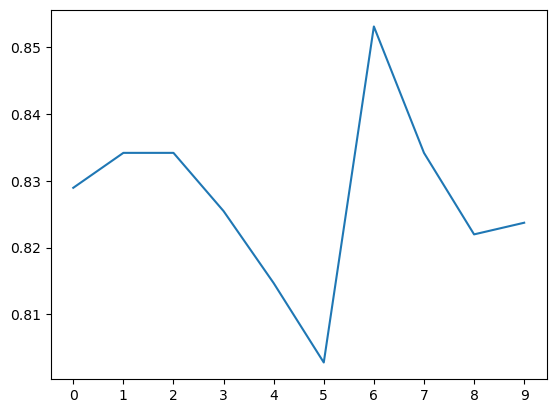

In [80]:
import matplotlib.pyplot as plt
acc_list = [value[0] for key, value in acc.items()]
xticks = [key for key, value in acc.items()]
yticks = [i for i in np.arange(0.8, 0.9, 0.05)]

plt.plot(acc_list)
plt.xticks(xticks)

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'data'
# For example, you can load your data like this:
# data = pd.read_csv('your_data.csv')

# Create pairplot
sns.pairplot(data)
plt.show()